In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
import os
import graphics as gx

# parameters
path = "./results/empirical_results/"
plot_period=1000

# 1 data preprocessing

In [2]:
# build fake reverse repo exp adj history
df_exposures = ef.get_df_exposures(lines=int(1e5))
dic_rev_repo_exp_adj = ep.build_from_exposures(df_exposures=df_exposures,path=f"{path}data/")

# build fake finrep data
df_finrep = ef.get_df_finrep()
dic_dashed_trajectory = ef.get_dic_dashed_trajectory(df_finrep)

100%|██████████| 100000/100000 [00:34<00:00, 2928.12it/s]


In [2]:
# pickle (faster)
dic_rev_repo_exp_adj = ep.load_dic_obs_matrix_reverse_repo(path=f"{path}data/")
df_finrep = ef.get_df_finrep()
dic_dashed_trajectory = ef.get_dic_dashed_trajectory(df_finrep)

# 2 metrics measurement

In [4]:
os.makedirs(f"{path}accounting_view/", exist_ok=True)

### 2.1.2 accounting items

#### A - static, distribution across banks, at several point in time 

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())
bank_items = list(dic_dashed_trajectory.values())[0].columns

# get df_powerlaw
df_powerlaw = em.get_powerlaw(
            dic_dashed_trajectory=dic_dashed_trajectory,
            days=days,
            plot_days=plot_days,
            plot_period=plot_period,
            path=f"{path}accounting_view/power_law/"
        )

# plot each powerlaw charts 
gx.plot_powerlaw(
            df_network_trajectory=df_powerlaw,
            days=days,
            plot_period=plot_period,
            path=f"{path}accounting_view/",
            plot_days=plot_days,
        )

# plot p-values across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw p-value {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/power_law/powerlaw_pvalue.pdf",
            )

# plot alpha of power laws across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw alpha {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/power_law/powerlaw_alpha.pdf",
            )

#### B - dynamic, distribution across time

In [ ]:
# distribution of deposits relative variation across time for each single bank
df_mmsr = ef.get_df_mmsr_unsecured(10000,freq="10min")
df_deposits_variations_by_bank = ep.get_df_deposits_variations_by_bank(df_mmsr, dic_dashed_trajectory, f"{path}/accounting_view/deposits/")

df = df_deposits_variations_by_bank[df_deposits_variations_by_bank>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/per_bank/positive/")

df = -df_deposits_variations_by_bank[df_deposits_variations_by_bank<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/per_bank/negative/")

#### C - mixed view across time and banks

In [ ]:
# distribution of deposits relative variation across time for each single bank
df_mmsr = ef.get_df_mmsr_unsecured(10000,freq="10min")
df_deposits_variations = ep.get_df_deposits_variation(df_mmsr, dic_dashed_trajectory, f"{path}/accounting_view/deposits/")

df = df_deposits_variations[df_deposits_variations>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/positive/")

df = -df_deposits_variations[df_deposits_variations<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/negative/")

## 2.2. exposure view

In [8]:
os.makedirs(f"{path}exposure_view/", exist_ok=True)

In [9]:
# get aggregated adjency matrices
dic_arr_binary_adj = ep.build_rolling_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=f"{path}data/")

In [10]:
# pickle (faster)
dic_arr_binary_adj = ep.load_dic_arr_binary_adj(path=f"{path}data/")

### 2.2.1 jaccard

In [11]:
days = list(dic_rev_repo_exp_adj.keys())

# get jaccard
df_jaccard = em.get_rev_repo_exposure_stats(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_jaccard,
            cols=df_jaccard.columns,
            file_name=f"{path}exposure_view/jaccard_index.pdf")

get jaccard


100%|██████████| 20833/20833 [00:04<00:00, 4186.66it/s]


### 2.2.2 density

In [12]:
days = list(dic_rev_repo_exp_adj.keys())

# get density
df_density = em.get_density(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_density,
            cols=df_density.columns,
            file_name=f"{path}exposure_view/network_density.pdf",
        )

get density


100%|██████████| 20833/20833 [00:04<00:00, 4294.83it/s]


### 2.2.3 degree distribution  (static, dashed)

In [13]:
days = list(dic_rev_repo_exp_adj.keys())

# get degree distribution
dic_in_degree, dic_out_degree, dic_degree = em.get_degree_distribution(dic_arr_binary_adj, path=f"{path}exposure_view/degree_distribution/")
gx.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    days,
    plot_period,
    f"{path}exposure_view/degree_distribution/")


get degree distribution


100%|██████████| 20834/20834 [00:10<00:00, 1911.33it/s]


### 2.2.4 degree stats

In [14]:
days = list(dic_rev_repo_exp_adj.keys())

# get av. degree
df_degree_stats = em.get_degree_stats(dic_degree, days, path=path)
gx.plot_network_trajectory(
            df=df_degree_stats,
            cols=df_degree_stats.columns,
            file_name=f"{path}exposure_view/degree_stats.pdf",
        )

get degree stats


100%|██████████| 20833/20833 [00:15<00:00, 1337.96it/s]


### 2.2.5 degree per asset

In [15]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(dic_rev_repo_exp_adj.values())[0].index

# select the days and banks (common between the 2 lists)
finrep_days = list(df_finrep["date"])
finrep_bank_ids = list(set(df_finrep["lei"]))
plot_days = fct.list_intersection(days, finrep_days)

# plot
gx.plot_degree_per_asset(
    dic_dashed_trajectory,
    dic_degree,
    bank_ids,
    days,
    plot_period,
    f"{path}exposure_view/degree_per_asset/",
    plot_days=plot_days,
    finrep_bank_ids=finrep_bank_ids)

### 2.2.6 network plots (static)

In [16]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(list(dic_rev_repo_exp_adj.values())[0].index)
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())

# plot the reverse repo network
gx.plot_weighted_adj_network(
    arr_rev_repo_exp_adj,
    dic_dashed_trajectory,
    days,
    plot_period,
    f"{path}exposure_view/weighted_adj_network/",
    "reverse repo",
    bank_ids=bank_ids,
    plot_days=plot_days,
)

### 2.2.6 core periphery

In [ ]:
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
days = list(dic_rev_repo_exp_adj.keys())

# get df_cpnet
df_cpnet = em.get_cpnet(
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/core-periphery/",
            )

# Plot the core-periphery struture
gx.plot_cpnet(
                df_network_trajectory=df_cpnet,
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/",
            )

# # read csv (faster)
# df_cpnet = pd.read_csv(f"{path}exposure_view/core-periphery/df_cpnet.csv", index_col=0)
# df_cpnet.index = pd.to_datetime(df_cpnet.index)

# plot the time evolution of p-values for each aggregation level
for fig in par.figs_cpnet_pvalues:
    gx.plot_network_trajectory(
            df=df_cpnet,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

## 2.3 transaction view

In [18]:
os.makedirs(f"{path}transaction_view/", exist_ok=True)

### 2.3.1 av network

In [ ]:
# get df_reverse_repo_transactions

# 3 tools

## 3.1 examples of density / histogram in log - log

### pareto law

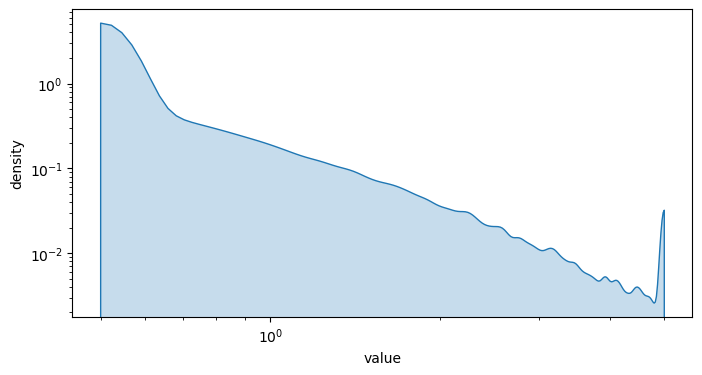

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

### student law

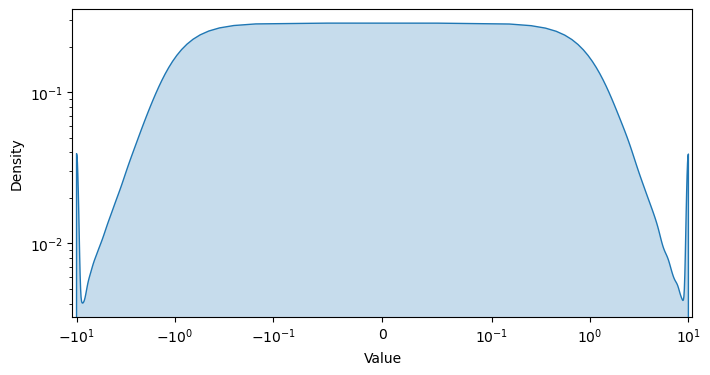

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

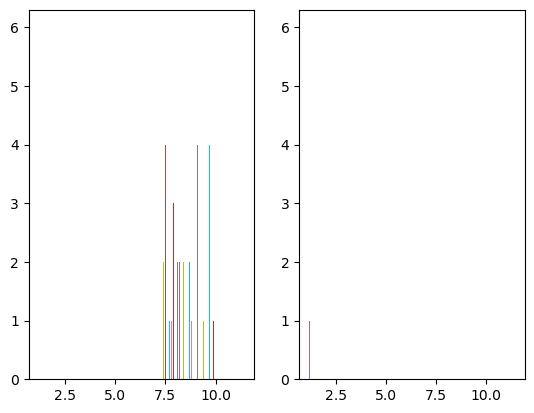

In [21]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## 3.3 power low fitting

Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


3.214195465860383
0.9720572221944399


<AxesSubplot: >

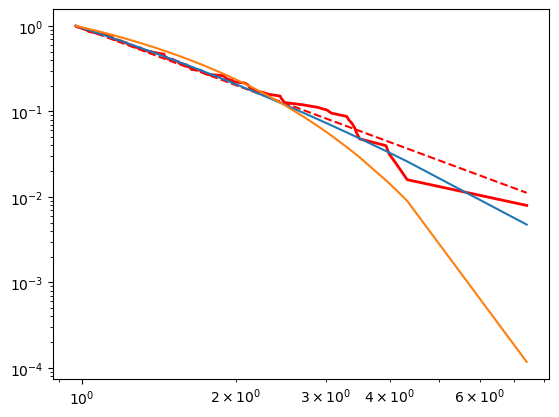

In [22]:
# fitting
import powerlaw
import numpy as np
sr_data = np.random.pareto(3,size=1000) # data can be list or numpy array
powerlaw_fit = powerlaw.Fit(sr_data)
print(powerlaw_fit.power_law.alpha)
print(powerlaw_fit.power_law.xmin)
R, p = powerlaw_fit.distribution_compare('power_law', 'exponential')
fig2 = powerlaw_fit.plot_ccdf(color = "r", linewidth = 2)
powerlaw_fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
powerlaw_fit.lognormal.plot_ccdf(ax=fig2)
powerlaw_fit.exponential.plot_ccdf(ax=fig2)